In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pyhf
import matplotlib.pyplot as plt
from publik import modifier
from publik import plot

## Define the binning

In [2]:
binning = np.array([2,3,4])

## Set up the mapping distribution

In [3]:
mapping_dist = np.array([[5.,0], [0,10.]])

## Set up the custom modifier

In [4]:
def null_dist(x, a=1., h1=2., h2=0.):
    return a*(1+x*h1-x**2*h2)

def alt_dist(x, a=1., h1=1., h2=1.):
    return a*(1-x*h1+x**2*h2)

In [5]:
new_params = {
                'a'   :{'inits': (2.,), 'bounds': ((0., 10.),), 'paramset_type': 'unconstrained'},
                'h'   :{'inits': (0.,0.), 'bounds': (), 'cov': [[1.,0.5],[0.5,1.]], 'paramset_type': 'constrained_by_normal'}
            }

cmod = modifier.Modifier(new_params, alt_dist, null_dist, mapping_dist, [binning])

(<Figure size 1400x500 with 2 Axes>,
 array([<Axes: title={'center': 'distributions'}>,
        <Axes: title={'center': 'weights'}>], dtype=object))

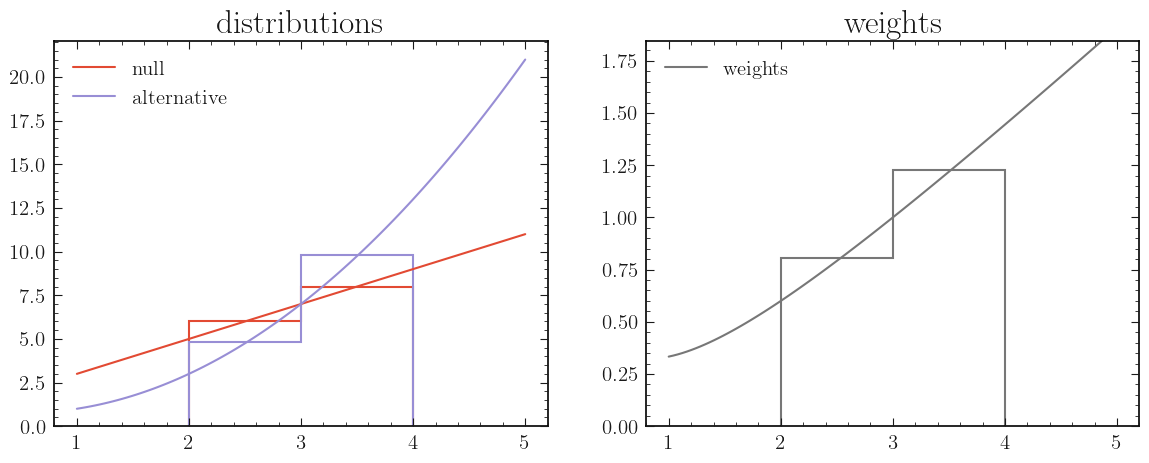

In [6]:
pars = [1,1]
lims = [1,5]
plot.dists(cmod, pars, lims, plot_weights=True)

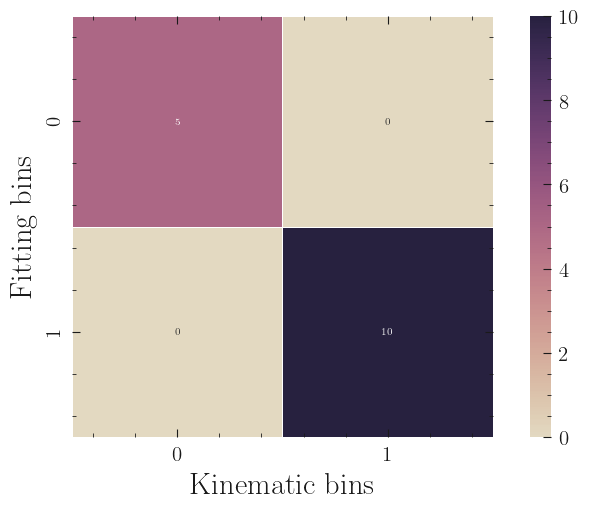

In [7]:
plot.map(cmod)

## Set up the model

In [8]:
spec = {
  "channels": [
    {
      "name": "singlechannel",
      "samples": [
        {
          "name": "signal",
          "data": [5.0, 10.0],
          "modifiers": [
            {
                "name": "mu",
                "type": "normfactor",
                "data": None
            }
          ]
        },
        {
          "name": "background",
          "data": [50.0, 60.0],
          "modifiers": [
            {
              "name": "uncorr_bkguncrt",
              "type": "shapesys",
              "data": [5.0, 12.0]
            }
          ]
        }
      ]
    }
  ]
}
model = pyhf.Model(spec)

custom_mod = {
                "name": "theory",
                "type": "custom",
                "data":
                    {
                        "expr": "weight_function",
                        "ibin": [0, 1]
                    }
              }

model = modifier.add_to_model(model, ['singlechannel'], ['signal'], cmod.expanded_pyhf, custom_mod)
model.spec

{'channels': [{'name': 'singlechannel',
   'samples': [{'name': 'signal',
     'data': [5.0, 10.0],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None},
      {'name': 'theory',
       'type': 'custom',
       'data': {'expr': 'weight_function', 'ibin': [0, 1]}}]},
    {'name': 'background',
     'data': [50.0, 60.0],
     'modifiers': [{'name': 'uncorr_bkguncrt',
       'type': 'shapesys',
       'data': [5.0, 12.0]}]}]}]}

## Generate some fake data

In [9]:
init = model.config.suggested_init()
init[0] = 5.
init[1] = 0.2
init[2] = -0.2

data = list(model.expected_actualdata(init)) + model.config.auxdata
data

[55.0, 70.0, 0.0, 0.0, 100.0, 25.0]

## Perform the fit

In [10]:
fixed = model.config.suggested_fixed()
# fixed[0] = True
fixed[3] = True

best_fit = pyhf.infer.mle.fit(data, model, fixed_params=fixed)

best_fit_dict = modifier.par_dict(model, best_fit)
best_fit_dict = cmod.rotate_pars(best_fit_dict)
best_fit_dict

{'a': 5.005772774488758,
 'h[0]': 0.02076646553527364,
 'h[1]': 0.04940709542817773,
 'mu': 1.0,
 'uncorr_bkguncrt': [0.9983759465685681, 1.0043298060366994]}

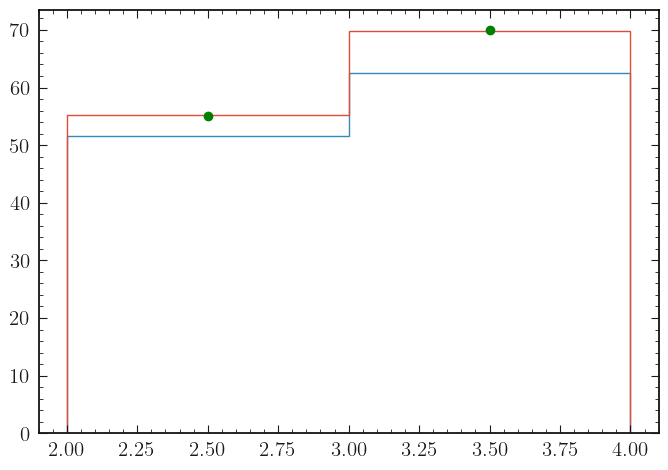

In [11]:
plt.stairs(model.expected_actualdata(model.config.suggested_init()), binning)
plt.stairs(model.expected_actualdata(best_fit), binning)
bin_cents = (binning[:-1] + binning[1:])/2
plt.plot(bin_cents, data[:2], 'og')